In [26]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## Criar amostras durante o treino

In [27]:
def sampling(args):
    """obtendo amostra de uma unidade gaussiana isotrópica
    # Arguments
        args (tensor): média e log da variância Q(z|X)
    # Returns
        z (tensor): amostra do vetor latente
    Usamos a log-variance e não a variance para melhorar a estabilidade numérica
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # Padrão random_normal média = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    # exp(0.5 * log(var)) = sqrt(var) = std
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [28]:
def plot_results(models, data, batch_size=128, img_size=64, manifold=10, channels=1, model_name="vae_hub"):

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")    
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(14, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "output_over_latent.png")
    # display a 2D manifold of digits
    n = manifold    
    figure = np.zeros((img_size * n, img_size * n))
    # linearly spaced coordinates corresponding to the 2D plot in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            img = x_decoded[0].reshape(img_size, img_size)
            figure[i * img_size: (i + 1) * img_size,
                   j * img_size: (j + 1) * img_size] = img

    plt.figure(figsize=(14, 14))
    start_range = img_size // 2
    end_range = (n - 1) * img_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.title('Applied VAE-GAN - AIHUB Masters', fontsize=24)
    plt.show()

## Preparação dos dados

In [29]:
from PIL import Image

channels = 1
image_size = 128
original_dim = channels * image_size * image_size

imgs = os.listdir('dataset/')
word2idx = {'a': 0, 'm': 1, 'c': 2, 'l': 3}

x_train = []
y_train = []
for img in imgs:
    pil_img = Image.open('dataset/'+img).resize((image_size, image_size))
    if channels == 1: pil_img = pil_img.convert('L')
    x = np.asarray(pil_img)
    x_train.append(x)
    y_train.append(word2idx[img[0]])

print('Shape do dataset:', np.array(x_train).shape)
x_train = np.reshape(x_train, [-1, original_dim])
y_train = np.array(y_train)

x_test = x_train.copy()
y_test = y_train.copy()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print('Shape do dataset:', x_train.shape, y_train.shape, x_test.shape, y_test.shape)

Shape do dataset: (20, 128, 128)
Shape do dataset: (20, 16384) (20,) (20, 16384) (20,)


## Preparação do modelo

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 16384)]      0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 512)          8389120     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_51[0][0]                   
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_51[0][0]                   
____________________________________________________________________________________________

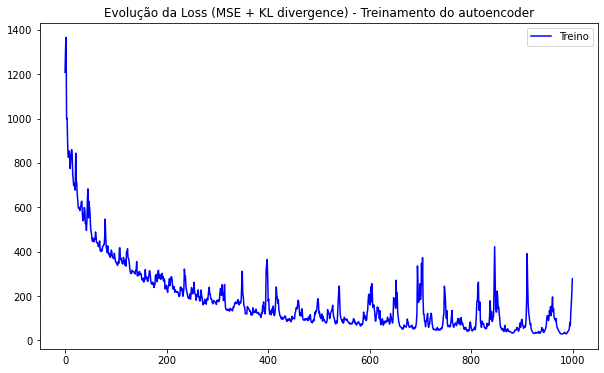

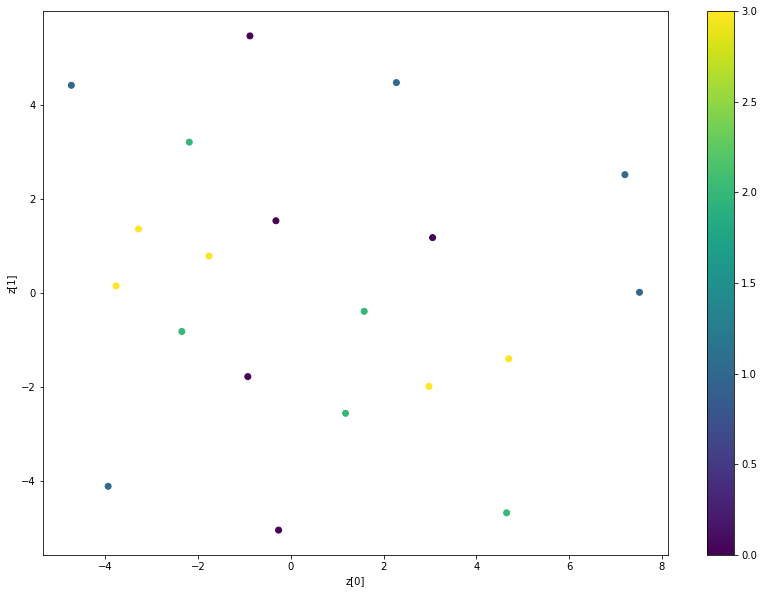

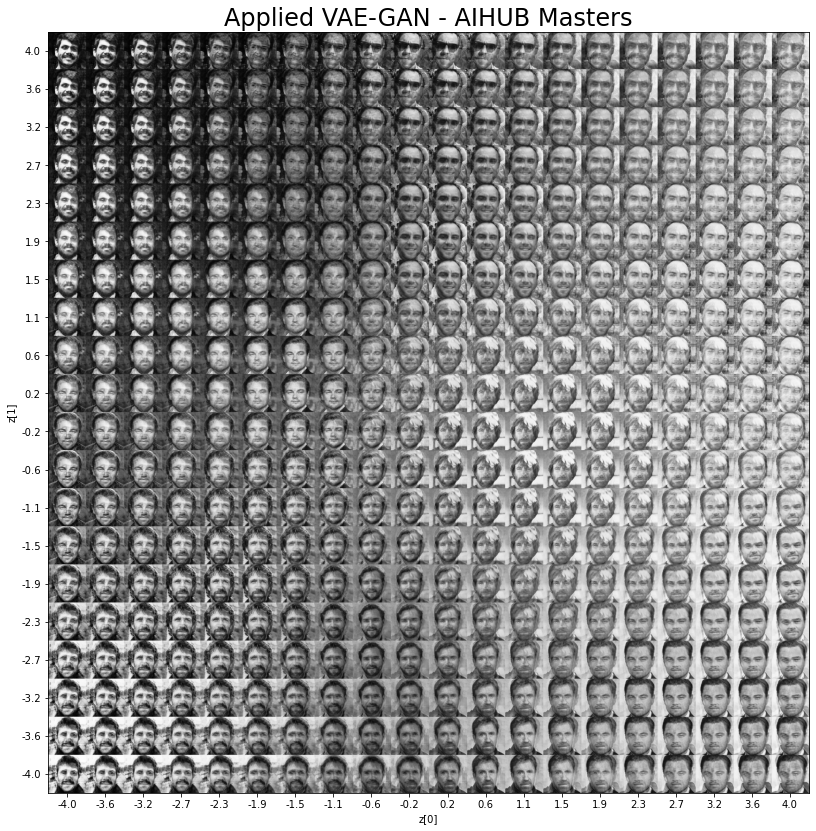

In [30]:
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 1
latent_dim = 2
epochs = 1000

inputs = Input(shape=input_shape, name='encoder_input')

x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# camada lambda para obter amostras
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE 
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

models = (encoder, decoder)
data = (x_test, y_test)

# LOSS personalizada com a divergência de KL
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# treinamento do modelo
history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, verbose=0)

print('\n\nLoss média nas 5 últimas épocas:', np.array(history.history['loss']).mean())

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], color='blue', label='Treino')
plt.legend()
plt.title('Evolução da Loss (MSE + KL divergence) - Treinamento do autoencoder')
plt.show()

plot_results(models, data, batch_size=batch_size, img_size=image_size, manifold=20, channels=channels, model_name="vae_mlp_hub")